# SN 2022abik 2022-12-1415

* [TNS Page for SN 2022abik](https://www.wis-tns.org/object/2022abik)

### Observing Notes

Another round of 30 60-second exposures each in g', r', and i', this time, proceeding across series rather than doing all of g' first.

TheSkyX crashed when approximately 80 of the planned 90 images had been taken.

### Calibration Photos

The calibration photos are in 2022-11-3001.

The bias photos should be discarded in favor of the 1-second (and 30-second) darks. It turns out TheSkyX ignores the exposure time set on bias photos and does some very rapid exposure. I would not have noticed this if I had not needed some 30-second bias files. The 30-second darks were needed because the i' flats required 30 seconds to get a reasonable value. The i' images are not analyzed below.

In [1]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
wunderimport matplotlib.pyplot as plt
%matplotlib inline
import astroalign as aa

# Only the following three lines should need to be adjusted, typically, from analysis to analysis.

observation_date = '2022-12-1415'
calibration_date = '2022-11-3001'
filters = ['g', 'r']
filter_full_names = ["Sloan g'", "Sloan r'"]

FIRST_FILTER = 0
SECOND_FILTER = 1

light_exposure = 60 * u.second
dark_exposure = light_exposure  # our method presumes this equality
flat_exposure = 1 * u.second
bias_exposure = flat_exposure  # our method presumes this equality

# Log stretch utility

from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        # The bizarre first conditional test on the next line avoids any attempt to transform NaNs.
        # if pixel_value != pixel_value or pixel_value <= 1.0:
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn

# Trimmed image reader utility (needed because our images have four columns of NaNs)

def delete_last_columns(arr, columns_to_delete):
    column_count = np.shape(arr)[1]
    del_arr = np.delete(arr, slice(column_count - columns_to_delete, column_count), 1)
    return del_arr

def trimmed_image_reader(file):
    img = CCDData.read(file, unit=u.adu)
    data = img.data
    trimmed_data = delete_last_columns(data, 4)
    img.data = trimmed_data
    return img


### Load Science and Calibration Images

In [2]:
# directories where the observation and calibration images being analyzed are kept

observation_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)
calibration_directory = os.path.join(os.path.expanduser('~'), 'Transients', calibration_date)

In [3]:
# subdirectories -- relative to observation and calibration directories

light_directories = [os.path.join(observation_directory, filter) for filter in filters]

# the 60-second darks
dark_directory = os.path.join(calibration_directory, 'dark')

# the 1-second g and r flats
flat_directories = [os.path.join(calibration_directory, 'flat', filter) for filter in filters]

# the 1-second darks/biases
bias_directory = os.path.join(calibration_directory, 'bias')

light_files_list = [ImageFileCollection(light_directory).files_filtered(include_path='True')
               for light_directory in light_directories]
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
flat_files_list = [ImageFileCollection(flat_directory).files_filtered(include_path='True')
               for flat_directory in flat_directories]
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')

lights_list = [[trimmed_image_reader(file) for file in light_files] for light_files in light_files_list]
darks = [trimmed_image_reader(file) for file in dark_files]
flats_list = [[trimmed_image_reader(file) for file in flat_files] for flat_files in flat_files_list]
biases = [trimmed_image_reader(file) for file in bias_files]

# the aligned directories are written to not read from
aligned_directory_list = [os.path.join(light_directory, 'aligned') for light_directory in light_directories]

for aligned_directory in aligned_directory_list:
    if not os.path.exists(aligned_directory):
        os.makedirs(aligned_directory)


Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


### Calibration

In [4]:
# Combine darks, flats, and biases

method = 'median'  # the method can be changed to 'average'

master_dark = combine(darks, method=method)
master_flat_list = [combine(flats, method=method) for flats in flats_list]
master_bias = combine(biases, method=method)

lights_subtracted_list = [[subtract_dark(light,
                                   master_dark,
                                   data_exposure=light_exposure,
                                   dark_exposure=dark_exposure,
                                   scale=False)
                           for light in lights] for lights in lights_list]

# Perform dark subtraction

master_flat_subtracted_list = [subtract_dark(master_flat,
                                       master_bias,
                                       data_exposure=flat_exposure,
                                       dark_exposure=bias_exposure,
                                       scale=False)
                               for master_flat in master_flat_list]

# Perform flat division
               
lights_calibrated_list = [[flat_correct(l, master_flat_subtracted_list[i]) for l in lights_subtracted_list[i]]
                          for i in range(len(filters))]

### Examine Uncalibrated and Calibrated Images

The displays below are north-down because this object was in the west. The first is with the g' filter and the second is with r'.

Compare with [TheSkyX chart, half-frame, north-down](https://brianhill.github.io/transient-astronomy/targets/SN_2022abik/target/TheSkyXScreenshot-HalfFrame-NorthDown.png).

In [5]:
# First grab some sample uncalibrated lights

sample_lights = [lights[0] for lights in lights_list]
sample_data_list = [np.asarray(sample_light) for sample_light in sample_lights]

# Median subtract

medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_data_list]
subtracted = [sample_data_list[i] - medians[i] for i in range(len(filters))]

# Then grab some sample calibrated lights

sample_calibrated_lights = [lights[0] for lights in lights_calibrated_list]
sample_calibrated_data_list = [np.asarray(sample_calibrated_light)
                               for sample_calibrated_light in sample_calibrated_lights]

# Median subtract

calibrated_medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_calibrated_data_list]
calibrated_subtracted = [sample_calibrated_data_list[i] - calibrated_medians[i] for i in range(len(filters))]

In [6]:
# Log stretch uncalibrated

stretch_function = log_stretch_transform(7, 50)
transform = np.vectorize(stretch_function)
transformed_sample_lights = [transform(data) for data in subtracted]

# Log stretch calibrated (potentially with a different stretching function)

stretch_function2 = log_stretch_transform(7, 50)
transform2 = np.vectorize(stretch_function2)
transformed_sample_calibrated_lights = [transform2(data) for data in calibrated_subtracted]

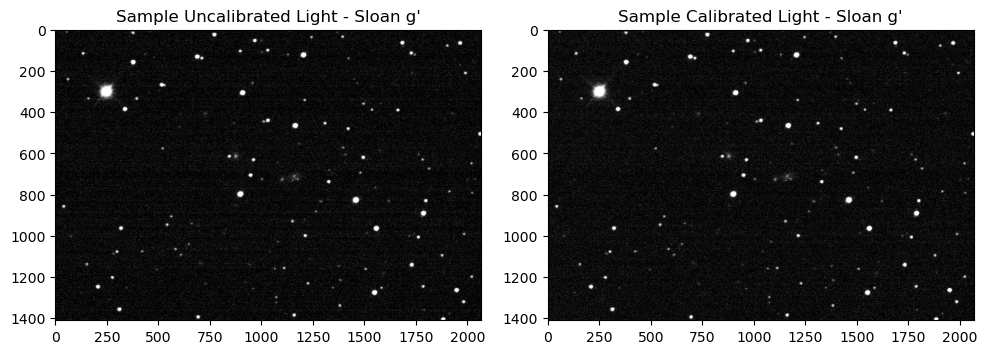

In [7]:
# Display first filter

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(transformed_sample_lights[FIRST_FILTER], cmap='gray')
axes[0].set_title("Sample Uncalibrated Light - " + filter_full_names[FIRST_FILTER])

axes[1].imshow(transformed_sample_calibrated_lights[FIRST_FILTER], cmap='gray')
axes[1].set_title("Sample Calibrated Light - " + filter_full_names[FIRST_FILTER])

plt.tight_layout()
plt.show()

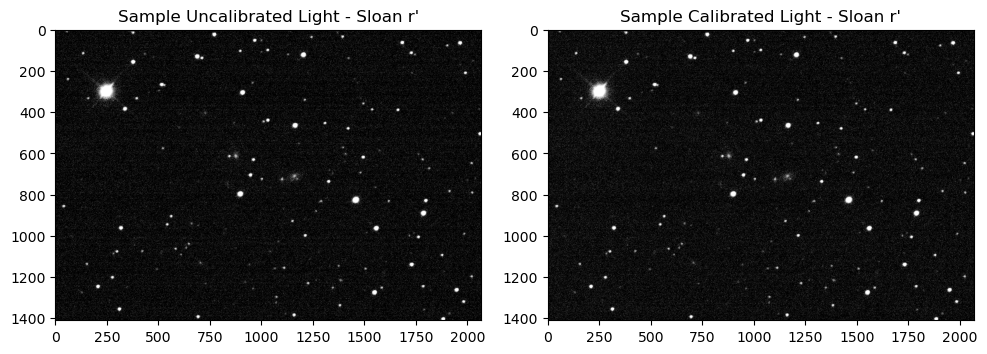

In [8]:
# Display second filter

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(transformed_sample_lights[SECOND_FILTER], cmap='gray')
axes[0].set_title("Sample Uncalibrated Light - " + filter_full_names[SECOND_FILTER])

axes[1].imshow(transformed_sample_calibrated_lights[SECOND_FILTER], cmap='gray')
axes[1].set_title("Sample Calibrated Light - " + filter_full_names[SECOND_FILTER])

plt.tight_layout()
plt.show()

### Create and Write the Aligned Lights

From here on, we only have use for the calibrated lights. The last step before combining them is alignment.

In [9]:
reference_light_list = [lights_calibrated[0] for lights_calibrated in lights_calibrated_list]

lights_aligned_with_footprints_list = [[aa.register(l, reference_light_list[i], detection_sigma=3.0) for
                                        l in lights_calibrated_list[i]] for i in range(len(filters))]

In [10]:
for i in range(len(filters)):
    # First we pick out all the stuff for a given filter
    lights = lights_list[i]
    light_files = light_files_list[i]
    lights_aligned_with_footprints = lights_aligned_with_footprints_list[i]
    aligned_directory = aligned_directory_list[i]
    for j in range(len(lights_aligned_with_footprints)):
        # Then we write all the files for that filter
        light_header = lights[j][0].header
        light_aligned_data = lights_aligned_with_footprints[j][0]
        aligned_file = os.path.join(aligned_directory, os.path.basename(light_files[j]))
        aligned_file2 = os.path.splitext(aligned_file)[0] + '_aligned.fit'
        fits.writeto(aligned_file2, light_aligned_data, light_header, overwrite=True)

### Stack the Lights

In [11]:
combined_light_list = []  # we'll have to do this for each filter

for i in range(len(filters)):
    aligned_directory = aligned_directory_list[i]
    aligned_files = ImageFileCollection(aligned_directory).files_filtered(include_path='True')
    combined_light_list.append(combine([CCDData.read(file, unit=u.adu) for file in aligned_files], method=method))

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


### Examine the Stacked Lights

In [28]:
stacked_data_list = [np.asarray(combined_light) for combined_light in combined_light_list]

# Median subtract

medians_list = [np.median(stacked_data, axis=1, keepdims=True) for stacked_data in stacked_data_list]
stacked_subtracted_list = [stacked_data_list[i] - medians_list[i] for i in range(len(filters))]

# Log stretch

stretch_function3 = log_stretch_transform(0, 100)
transform3 = np.vectorize(stretch_function3)
transformed_stacked_subtracted_list = [[transform3(data) for data in stacked_subtracted]
                                       for stacked_subtracted in stacked_subtracted_list]

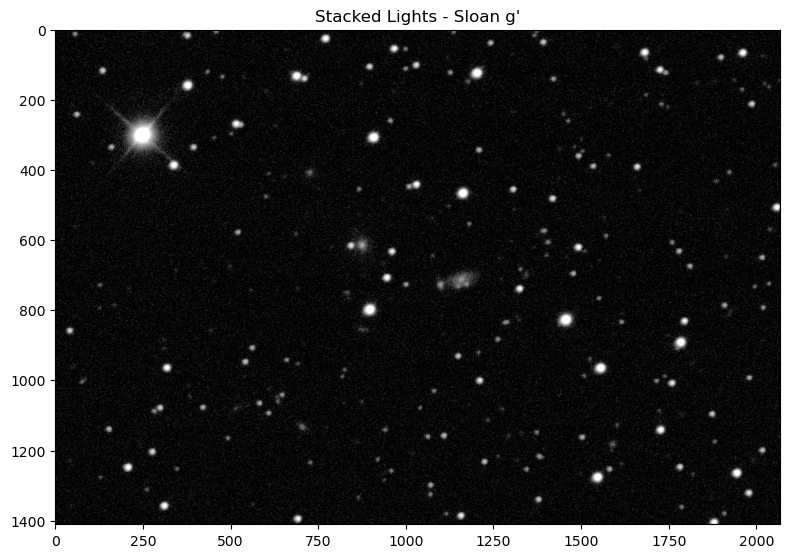

In [29]:
# First filter

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[FIRST_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[FIRST_FILTER])

plt.tight_layout()
plt.show()

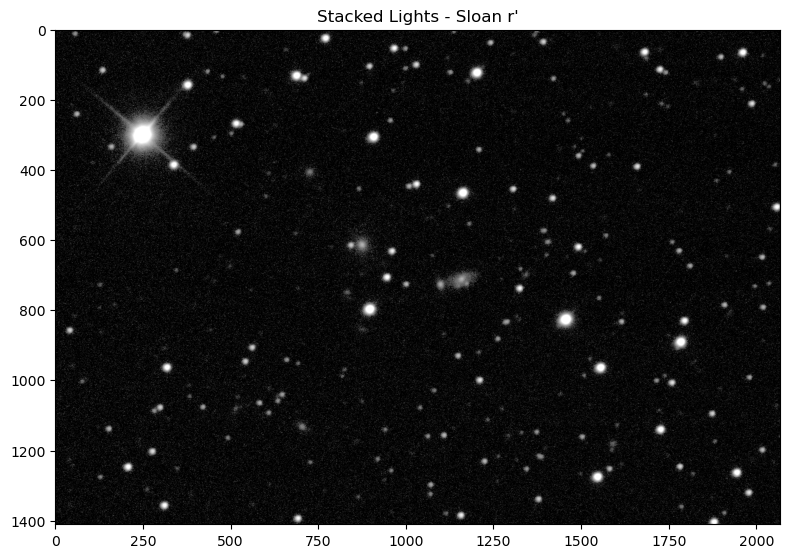

In [30]:
# Second filter

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SECOND_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SECOND_FILTER])

plt.tight_layout()
plt.show()